1. **Creating a Custom Dataset for your files**

    A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. Take a look at this implementation; the SatelliteImageClassification images are stored in a directory img_dir, and their labels are stored separately in a CSV file annotations_file.

    ```
    __init__
    ```
    The \__init__ function is run once when instantiating the Dataset object. We initialize the annotations file, and both transforms


    ```
    __len__
    ```
    The \__len__ function returns the number of samples in our dataset.


    ```
    __getitem__
    ```
    The \__getitem__ function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in self.img_labels, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.

In [1]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import os
from torchvision import transforms
from PIL import Image

# ฟังก์ชันสำหรับอ่านไฟล์ CSV
def read_csv(path):
    return pd.read_csv(path, names=['image', 'label'], header=None)

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, base_path, image_transform=None, depth_transform=None):
        self.data = read_csv(csv_file)  # โหลด DataFrame
        self.base_path = base_path  # กำหนด path หลักของไฟล์ภาพ
        self.image_transform = image_transform  # Transformation สำหรับภาพ
        self.depth_transform = depth_transform  # Transformation สำหรับ depth map

    def get_image_pair(self, idx):
        """โหลดภาพและ depth map"""
        img_path = os.path.join(self.base_path, self.data.iloc[idx, 0])
        depth_path = os.path.join(self.base_path, self.data.iloc[idx, 1])

        # ตรวจสอบว่าไฟล์มีอยู่หรือไม่
        if not os.path.exists(img_path) or not os.path.exists(depth_path):
            raise FileNotFoundError(f"File not found: {img_path} or {depth_path}")

        # ใช้ PIL แทน OpenCV เพื่อโหลดภาพและ depth map
        image = Image.open(img_path).convert('RGB')
        depth = Image.open(depth_path).convert('L')

        return image, depth

    def __getitem__(self, idx):
        """ดึงข้อมูลหนึ่งตัวอย่างจาก Dataset"""
        image, depth = self.get_image_pair(idx)  # โหลดภาพและ depth map

        # ใช้ transformations กับภาพและ depth map (ถ้ามี)
        if self.image_transform:
            image = self.image_transform(image)

        if self.depth_transform:
            depth = self.depth_transform(depth)

        # แปลง depth map เป็น float32 และ Normalize
        # depth = depth.float() / 255.0  # ควรเป็นช่วง [0, 1]

        return image, depth

    def __len__(self):
        """คืนค่าความยาวของ Dataset"""
        return len(self.data)



    - Preparing your data for training with DataLoaders

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch 0:
Image shape: torch.Size([8, 3, 256, 320]), Depth shape: torch.Size([8, 1, 256, 320])
Image Min: -1.0, Max: 1.0
Depth Min: 0.07058823853731155, Max: 0.6392157077789307


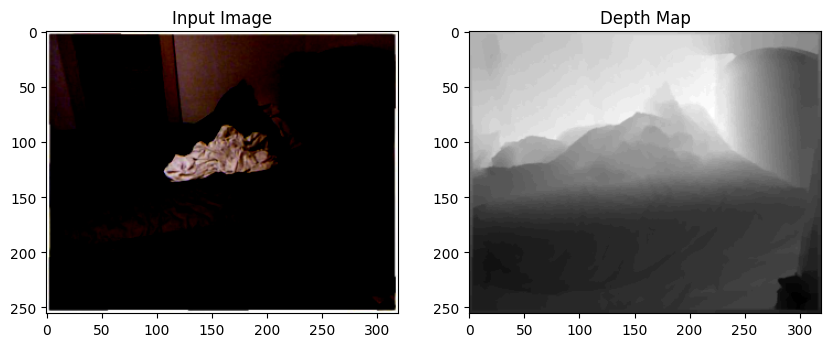

In [2]:
from torchvision import transforms

# ขนาด batch size
batch_size = 8

image_transform = transforms.Compose([
    transforms.Resize((256, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Transformations สำหรับ depth map
depth_transform = transforms.Compose([
    transforms.Resize((256, 320)),
    transforms.ToTensor(),  
    # transforms.Lambda(lambda x: x.float() / 255.0)  # Normalize เป็นช่วง [0, 1]
])
# สร้าง Dataset จาก CSV
base_path = './'
csv_file = os.path.join(base_path, './data/nyu2_train.csv')

dataset = CustomImageDataset(
    csv_file=csv_file, 
    base_path=base_path, 
    image_transform=image_transform, 
    depth_transform=depth_transform
)


# แบ่ง Dataset เป็น Train และ Validation
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# สร้าง DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# ตรวจสอบข้อมูลจาก DataLoader
import matplotlib.pyplot as plt
for i, (image, depth) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"Image shape: {image.shape}, Depth shape: {depth.shape}")
    print(f"Image Min: {image.min()}, Max: {image.max()}")
    print(f"Depth Min: {depth.min()}, Max: {depth.max()}")

    # แสดงผลภาพและ depth map ตัวอย่าง
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image[0].permute(1, 2, 0).numpy())
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.imshow(depth[0].squeeze(0).numpy(), cmap='gray')
    plt.title("Depth Map")

    plt.show()

    if i == 0:
        break

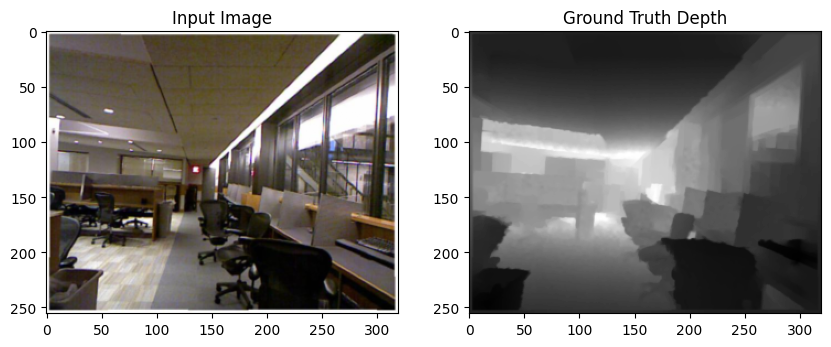

Depth Min: 31, Max: 254


In [3]:
import matplotlib.pyplot as plt

def show_sample_from_loader(loader):
    image, depth = next(iter(loader))

    image_np = image[0].permute(1, 2, 0).numpy()
    image_np = (image_np * 0.5) + 0.5  # ย้อน Normalize
    depth_np = depth[0].squeeze(0).numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title('Input Image')

    plt.subplot(1, 2, 2)
    plt.imshow(depth_np, cmap='gray')
    plt.title('Ground Truth Depth')

    plt.show()

    image, depth = dataset.get_image_pair(0)  # ตัวอย่างแรก


    print(f"Depth Min: {np.min(depth)}, Max: {np.max(depth)}")
show_sample_from_loader(train_loader)

    - Show sample image from the DataLoader

2. Define a Convolutional Neural Network

In [5]:
import torch
import segmentation_models_pytorch as smp

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CLASSES= 1
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels= 3,  
    classes=CLASSES,  # Output เป็น depth map (1 channel)
    # activation='sigmoid'  # ใช้ None เพื่อไม่บังคับค่า output
     activation=None  
)
model.to(DEVICE)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [6]:
import torch.optim as optim
import torch
import torch.nn as nn


criterion = nn.MSELoss()  # ใช้ Mean Squared Error ในการประเมิน depth
optimizer = optim.Adam(model.parameters(), lr=1e-4)

3. Define a Loss function and optimizer

Epoch [1/8], Train Loss: 0.0152, Val Loss: 0.0031
Model for epoch 1 saved as ./epoch_1_model.pth
Best model saved!


Epoch [2/8], Train Loss: 0.0029, Val Loss: 0.0027
Model for epoch 2 saved as ./epoch_2_model.pth
Best model saved!


Epoch [3/8], Train Loss: 0.0019, Val Loss: 0.0016
Model for epoch 3 saved as ./epoch_3_model.pth
Best model saved!


Epoch [4/8], Train Loss: 0.0013, Val Loss: 0.0014
Model for epoch 4 saved as ./epoch_4_model.pth
Best model saved!


Epoch [5/8], Train Loss: 0.0010, Val Loss: 0.0015
Model for epoch 5 saved as ./epoch_5_model.pth


Epoch [6/8], Train Loss: 0.0008, Val Loss: 0.0021
Model for epoch 6 saved as ./epoch_6_model.pth


Epoch [7/8], Train Loss: 0.0008, Val Loss: 0.0008
Model for epoch 7 saved as ./epoch_7_model.pth
Best model saved!


Epoch [8/8], Train Loss: 0.0006, Val Loss: 0.0012
Model for epoch 8 saved as ./epoch_8_model.pth
Final model saved!


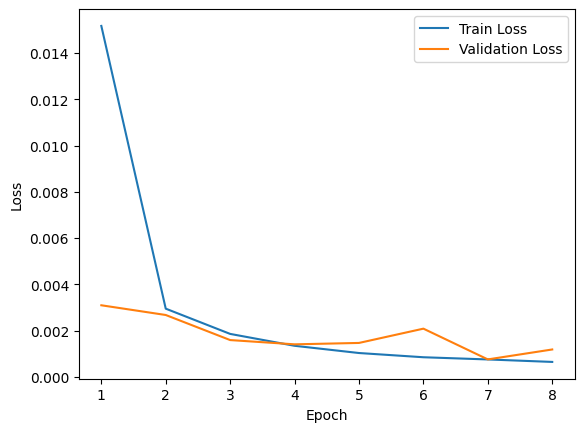

In [7]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

num_epochs = 8
train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Train", leave=False)

    for images, depths in train_loop:
        images, depths = images.to(DEVICE), depths.to(DEVICE)
        
        # คำนวณ Prediction และ Loss
        outputs = model(images)
        loss = criterion(outputs, depths)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)

    # Validate Phase
    model.eval()
    val_loss = 0.0
    val_loop = tqdm(valid_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Validate", leave=False)

    with torch.no_grad():
        for images, depths in val_loop:
            images, depths = images.to(DEVICE), depths.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, depths)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(valid_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # บันทึกโมเดลทุก epoch
    epoch_model_path = f'./epoch_{epoch+1}_model.pth'
    torch.save(model.state_dict(), epoch_model_path)
    print(f'Model for epoch {epoch+1} saved as {epoch_model_path}')

    # บันทึก Best Model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), './best_model.pth')
        print('Best model saved!')

# บันทึกโมเดลสุดท้าย
torch.save(model.state_dict(), './final_model.pth')
print('Final model saved!')

# Plot Training and Validation Loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:
torch.save(model.state_dict(), './final_model.pth')
